In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from dataloader import load_dataset
from scripts import *
import numpy as np

In [2]:
num_particles = 13

# Convert coordinates to graphs. 

## Load Data 

We get our data from a monte carlo simulation of 13 self assembling atoms subject to the lennard jones potential $V(r) = \sum_{ij} \epsilon \left ( \frac{1}{r^{12}_{ij}} - \frac{1}{r^{6}_{ij}} \right)$. The particles are moving based on a stochastic process modelling brownian motion. We load the dataset consisting of 5001 atomic clusters and center them around the origin. We will denote this data with $\mathcal{X} \in \mathbb{R}^{13 \times 3}$. 

In [3]:

coordinates, potentials_ = load_dataset("../data/Lj_018f.txt", 3)
coordinates = center_dataset(coordinates)
total_samples = len(coordinates)

In [4]:
idx = np.argsort(potentials_)
coordinates = np.array([coordinates[i] for i in idx])
potentials = np.array([potentials_[i] for i in idx])

## Visualizing the Dataset
Since it is impossible to visualize a 39 dimensional (13 particles $\times$ 3 coordinates) space, We plot all of the clusters in $\mathbb{R}^3$ space. Hence every point in $\mathcal{X}$ will have 13 points in $\mathbb{R^3}$, colored by the potential energy. We can observe a pattern based on the fact that the closer clusters are, the lower the energy and hence, we get a loose feel on the nature of our data in this manner. 

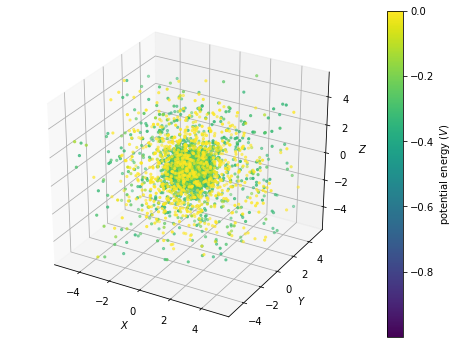

In [5]:
#collapse the dataset to 3 dimensions
X = np.reshape(coordinates, [-1, 3])
# plot the dataset in 3d space and color with potential 
fig1 = plt.figure(figsize=(8, 6))
ax = fig1.add_subplot(111, projection='3d')
ax.set_xlabel('$X$')
ax.set_ylabel('$Y$')
ax.set_zlabel('$Z$')
a = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=np.array(potentials).repeat(3), s=5)
plt.colorbar(a, label='potential energy ($V$)')
plt.savefig("statespace_04_non.png")

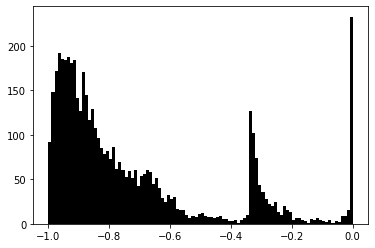

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(np.reshape(potentials, len(potentials)), bins=100, color='black')
plt.savefig("potentials04.png")

## Generating adjacency matrices

Our next step is to transform the coordinate space to a graphical representation defined via adjacency matrices. The 13 particles are mapped to each other based on a definition of bond. We define two matrices, namely R and G. R maps particles based on eucledian distance and G maps particles based on a binary value determined by a cutoff ($\rho$). 
$$
R_{ij} = ||x_i - x_j||  \\
$$
$$
G_{ij} = \begin{cases} 1 \mbox{,} & \mbox{if } R_{ij} \leq \rho \\ \mbox{0,} & \mbox{else} \end{cases}
$$
We set the cutoff distance as $\rho = 1.2 \sigma$ with $\sigma$ being the simulation unit. We define both R and G for all 5001 clusters in the dataset. This cutoff is determined based on the physics of the interaction potential. 

In [7]:
#sample_size = total_samples
sample_size = len(coordinates) #use lesser samples for faster computation
adjacency_matrices = [get_adjacent_matrices(config, 1.2) for config in coordinates]
R = np.square(np.array(adjacency_matrices)[:, 0][:sample_size])
G = np.array(adjacency_matrices)[:, 1][:sample_size]
print(R.shape, G.shape)

(5001, 3, 3) (5001, 3, 3)


In [8]:
#extract some information from the feature space 
from itertools import combinations
side_length_space = [] #side lengths between each particles
perimeter = [] #side lengths between each particles
n_bonds = np.zeros(len(coordinates)) #number of bonds in the structure
cut_off_distance = 1.5 #sigma  
num_particles = 3
rg = []
for i in range(len(coordinates)):
    side_length_space.append([])
    particles = np.reshape(coordinates[i], [3, 3])
    perms = combinations(particles, 2) 
    for perm in perms:
        side_length_space[i].append(distance(perm[0] , perm[1]))   
    rg.append(np.sqrt(np.sum(np.square(side_length_space[i])))/3)
    perimeter.append(np.sum(side_length_space[i]))
    for j in range(len(side_length_space[i])):
        if side_length_space[i][j] < cut_off_distance:
            n_bonds[i] += 1 

## Calculating graph laplacian matrices for adjacency matrices

Our next step is to calculate the laplacian matrices for $R$ and $G$. A laplacian matrix for an symmetric adjacency matrix $A$ is defined as
$$
L = D - A.
$$
Where, D is a diagonal matrix holding degrees (number of connections) of each particle in case of $G$. For $R$, $D$ will hold a continous form of the degrees. For our case, we interpret it as the surrounding surface area around a particle. We define two adjacency matrices for $R$ and $G$ namely, $L_R$ and $L_G$.

In [9]:
L_R = np.zeros(shape=R.shape)
L_G = np.zeros(shape=G.shape)
for i in range(sample_size):
    L_R[i] = np.diag(np.sum(R[i], axis=1)) - R[i]    #L_R = D_R - R
    L_G[i] = np.diag(np.sum(G[i], axis=1)) - G[i]    #L_G = D_G - G

## Eigendecomposition of laplacian matrices as a representation of the graphs

We define a spectral representation of atomic clusters calculated via eigen values and vectors of the graph laplacians  ( {$\Lambda_R$, $\Psi_R$} and {$\Lambda_G$, $\Psi_G$}). 

In [10]:
L_R_lmbd, L_R_psi = np.linalg.eig(L_R)
L_G_lmbd, L_G_psi = np.linalg.eig(L_G)

# Diffusion Map Algorithm for Generating Supspaces of $\mathcal{X}$

## 1. Distance Kernel Calculation
We define a cross correlation distance kernel $K \in \mathbb{R}^{5001 \times 5001}$, quantifying structural differences among the clusters in the dataset. This is where the novelty of our work lies as we propose a spectral distance between two clusters $d_{i,j}=\sum_k |\Lambda_i^k - \Lambda_j^k|$, where $\Lambda = \left\{\lambda_1 < \lambda_2 < \lambda_3 < \dots < \lambda_n \right\}$ is the eigenspectrum of the graph laplacian. I sort the eigenvalue out put ensure that the the eigenvalues are arranged in decreasing order
$$
[K]_{ij} = \left[e^{\frac{-d_{ij}^2}{2\epsilon}}\right]_{ij}
$$
Where, 
$$
d_{ij} = \sum_k |\Lambda_i^k - \Lambda_j^k|
$$
We know that the laplacian matrix is invariant under translation and rotation as it is a function of eucledian distance. We observe that the eigenvalues/vectors are invariant under index permutation. For a graph laplacian $L$, the node indices can be swapped using permutation matrices ($P$) as $ L \longrightarrow PLP^{-1}$. The eigenvalues of $L$ are solutions of the charecteristic polynomial $p : det(\lambda I - A) = 0$. If we subject A to a transformation which swaps particle indexes using permutation matrices, it can be seen that the eigenvalues are invariant to the permutation transformation. 
$$
det(\lambda I - PAP^{-1}) = det(P(\lambda I - A)P^{-1}) =det(P)det(\lambda I - A)det(P^{-1})= det(\lambda I - A)
$$
Consider a graph $\mathcal{G} = \{V, E\}$ with the adjacency matrix $A$ and laplacian matrix $L$, the objective is to embed $\mathcal{G}$ on a space $\mathcal{X} \in \mathbb{R}$, such that the transformed coordinates of the connected nodes ($\boldsymbol{x}_i \in \mathcal{X}$) are close to each other and disconnected nodes placed further. For nodes $\{ \boldsymbol{v}_i \in V\}$, this objective can be set up as a minimization problem s shown below
$$
 argmin_{x_1, x_2 \dots x_n \in \mathcal{X}}  A_{ij}||x(v_i) - x(v_j)||^2 =  argmin_{x_1, x_2 \dots x_n \in \mathcal{X}} ||\boldsymbol{x}_i^{t}L\boldsymbol{x}_i||^2.
$$
The left hand side of equation is the \textit{Dirchlet Sum} of the $L$. If $u_i$ and $u_j$ are connected, the distance between $\boldsymbol{x}(\boldsymbol{v}_i)$ and $\boldsymbol{x}(\boldsymbol{v}_j)$  should be minimized. This function can be rewritten as the right hand side of the equation \ref{dirchlet} in terms of the laplacian $L$. The solution to this problem are the eigenvectors of $L$. According to the spectral theorem, the eigenvectors of a symmetric matrix form an orthogonal basis. Therefore, for eigenvectors of $L$, $\psi$ and $\phi$, $\implies \boldsymbol{\psi}_i^{t}L\boldsymbol{\phi}_i = \boldsymbol{\psi}_i^{t}\lambda_i\boldsymbol{\phi}_i = \lambda_i\boldsymbol{\psi}_i^{t}\boldsymbol{\phi}_i = 0$. Hence, the eigenvectors of $L$ provide an eucledian embedding of the graph adjacency matrix $A$. We have already established that the eigenvalues are invariant under permutation. The eigenvectors however, need 


In [11]:
def normalize(X):
    for i in range(len(X[:, 0])):
        X[:, i] = X[:, i]/np.linalg.norm(X[:, i])
    return X
'''
Cross correlation distance matrices
d_R_lmbd = eigenvalue distance for continous distance
d_G_lmbd = eigenvalue distance for binary distance
d_R_psi  = eigenvector distance for continous distance
d_G_psi  = eigenvector distance for binary distance
'''
d_R_lmbd = np.zeros(shape=[sample_size, sample_size])
d_G_lmbd = np.zeros(shape=[sample_size, sample_size])
d_R_psi  = np.zeros(shape=[sample_size, sample_size])
d_G_psi  = np.zeros(shape=[sample_size, sample_size])
for i in range(sample_size):
    idx_Ri = np.argsort(L_R_lmbd[i])
    idx_Gi = np.argsort(L_G_lmbd[i])
    for j in range(i, sample_size):
        idx_Gj = np.argsort(L_G_lmbd[j])
        idx_Rj = np.argsort(L_R_lmbd[j])
        #arrange eigenvalues in increasing order
        Rlmbd_i = L_R_lmbd[i][idx_Ri]
        Rlmbd_j = L_R_lmbd[j][idx_Rj]
        Glmbd_i = L_G_lmbd[i][idx_Gi]
        Glmbd_j = L_G_lmbd[j][idx_Gj]
        #rearranging eigenvectors based on sorted indices
        Rpsi_i = np.sort(abs(L_R_psi[i]).flatten())
        Rpsi_j = np.sort(abs(L_R_psi[j]).flatten())
        Gpsi_i = np.sort(abs(L_G_psi[i]).flatten())
        Gpsi_j = np.sort(abs(L_G_psi[j]).flatten())
        #distance calculation (L1 norm)
        N_inv = 1./num_particles
        d_R_lmbd[i][j] = N_inv*np.sum(abs(Rlmbd_i - Rlmbd_j))
        d_G_lmbd[i][j] = N_inv*np.sum(abs(Glmbd_i - Glmbd_j)) 
        d_R_lmbd[j][i] = d_R_lmbd[i][j]
        d_G_lmbd[j][i] = d_G_lmbd[i][j]
        #eigenvector distance 
        d_R_psi[i][j] = np.linalg.norm(Rpsi_i-Rpsi_j)
        d_G_psi[i][j] = np.linalg.norm(Gpsi_i-Gpsi_j)
        d_R_psi[j][i] = d_R_psi[i][j]
        d_G_psi[j][i] = d_G_psi[i][j]

### Choosing diffusion bandwidth $\epsilon$



In [12]:
def get_kernel_bandwidth(d):
    #selecting kernel bandwidth
    compute_A = lambda eps : np.sum(np.exp(-d**2/(2.*eps)))
    # Values of epsilon in base 2 we want to scan. 
    eps =np.exp(np.arange(-15.,15.,1))
    # Pre-allocate array containing sum(Aij). 
    Aij = np.zeros(eps.shape)
    # Loop through values of epsilon and evaluate matrix sum.
    for i in range(len(eps)): 
        A_ = compute_A(eps[i])
        Aij[i] = A_.sum()
    return np.log(eps), np.log(Aij)
#generate bandwidth samples for all the distance matrices
bwdth_Glmbd_x, bwdth_Glmbd_y = get_kernel_bandwidth(d_G_lmbd)
bwdth_Rlmbd_x, bwdth_Rlmbd_y = get_kernel_bandwidth(d_R_lmbd)
bwdth_Gpsi_x, bwdth_Gpsi_y   = get_kernel_bandwidth(d_G_psi)
bwdth_Rpsi_x, bwdth_Rpsi_y   = get_kernel_bandwidth(d_R_psi)

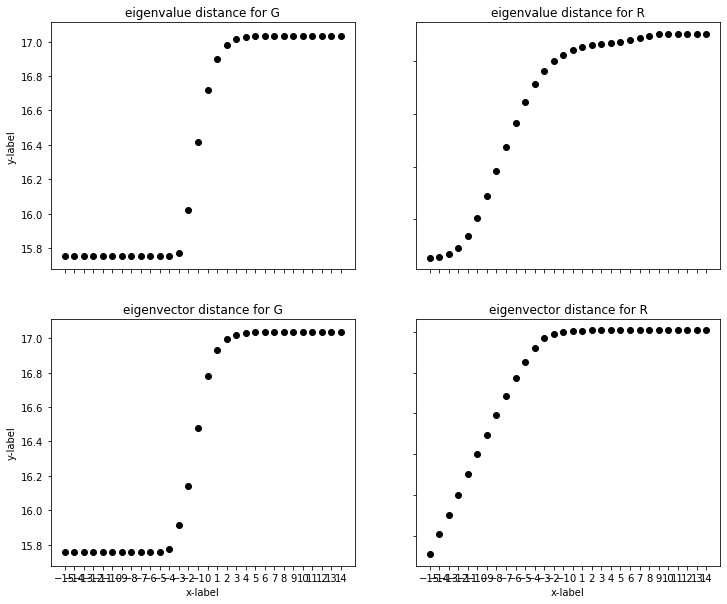

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs[0, 0].scatter(bwdth_Glmbd_x.real, bwdth_Glmbd_y.real, c='black')
axs[0, 0].set_title('eigenvalue distance for G')
axs[0, 1].scatter(bwdth_Rlmbd_x.real, bwdth_Rlmbd_y.real, c='black')
axs[0, 1].set_title('eigenvalue distance for R')
axs[1, 0].scatter(bwdth_Gpsi_x.real, bwdth_Gpsi_y.real, c='black')
axs[1, 0].set_title('eigenvector distance for G')
axs[1, 1].scatter(bwdth_Rpsi_x.real, bwdth_Rpsi_y.real, c='black')
axs[1, 1].set_title('eigenvector distance for R')
for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')
    ax.set_xticks(np.arange(-15.,15.,1))
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [14]:
Glmbd_eps = np.exp(1.)
Rlmbd_eps = np.exp(11.)
Gpsi_eps  = np.exp(1)
Rpsi_eps  = np.exp(-4.)

In [29]:
c

NameError: name 'c' is not defined

In [15]:
#calculate markov transition matrix 
K_Rlmbd = np.exp(-d_R_lmbd**2/(2.*Rlmbd_eps))
K_Glmbd = np.exp(-d_G_lmbd**2/(2.*Glmbd_eps))
K_Rpsi  = np.exp(-d_R_psi**2/(2.*Rpsi_eps))
K_Gpsi  = np.exp(-d_G_psi**2/(2.*Gpsi_eps))
#Normalize kernel to generate markov transition matrix (M)
M_Rlmbd = np.linalg.inv(np.diag(np.sum(K_Rlmbd, axis=1))) @ K_Rlmbd
M_Glmbd = np.linalg.inv(np.diag(np.sum(K_Glmbd, axis=1))) @ K_Glmbd
M_Rpsi  = np.linalg.inv(np.diag(np.sum(K_Rpsi , axis=1))) @ K_Rpsi 
M_Gpsi  = np.linalg.inv(np.diag(np.sum(K_Gpsi , axis=1))) @ K_Gpsi 
#calculate the eigenspace 
evals_Rlmbd, evecs_Rlmbd = np.linalg.eig(M_Rlmbd)
evals_Glmbd, evecs_Glmbd = np.linalg.eig(M_Glmbd)
evals_Rpsi , evecs_Rpsi  = np.linalg.eig(M_Rpsi )
evals_Gpsi , evecs_Gpsi  = np.linalg.eig(M_Gpsi )

In [20]:
bwdth_Glmbd = np.column_stack((bwdth_Glmbd_x, bwdth_Glmbd_y))
bwdth_Gpsi= np.column_stack((bwdth_Gpsi_x, bwdth_Gpsi_y))
bwdth_Rlmbd = np.column_stack((bwdth_Rlmbd_x, bwdth_Rlmbd_y))
bwdth_Rpsi = np.column_stack((bwdth_Rpsi_x, bwdth_Rpsi_y))

In [21]:
np.savetxt("../thesis_data/reduced3p_Rlmbd.txt", evecs_Rlmbd[:, 1:4])
np.savetxt( "../thesis_data/reduced3p_Glmbd.txt",evecs_Glmbd[:, 1:4])
np.savetxt(  "../thesis_data/reduced3p_Rpsi.txt",evecs_Rpsi[:, 1:4])
np.savetxt(  "../thesis_data/reduced3p_Gpsi.txt",evecs_Gpsi[:, 1:4])
np.savetxt("../thesis_data/evals3p_Glmbd.txt",evals_Glmbd)
np.savetxt("../thesis_data/evals3p_Gpsi.txt",evals_Gpsi)
np.savetxt("../thesis_data/evals3p_Rlmbd.txt",evals_Rlmbd)
np.savetxt("../thesis_data/evals3p_Rpsi.txt",evals_Rpsi)
np.savetxt("../thesis_data/bwdth3p_Glmbd.txt",bwdth_Glmbd)
np.savetxt("../thesis_data/bwdth3p_Gpsi.txt",bwdth_Gpsi)
np.savetxt("../thesis_data/bwdth3p_Rlmbd.txt",bwdth_Rlmbd)
np.savetxt("../thesis_data/bwdth3p_Rpsi.txt",bwdth_Rpsi)

In [16]:
evecs_Rlmbd = normalize(evecs_Rlmbd )
evecs_Glmbd = normalize(evecs_Glmbd )
evecs_Rpsi  = normalize(evecs_Rpsi  )
evecs_Gpsi  = normalize(evecs_Gpsi  )

C:\Users\Aditya Dendukuri\Anaconda3\lib\site-packages\numpy\core\numeric.py:591: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


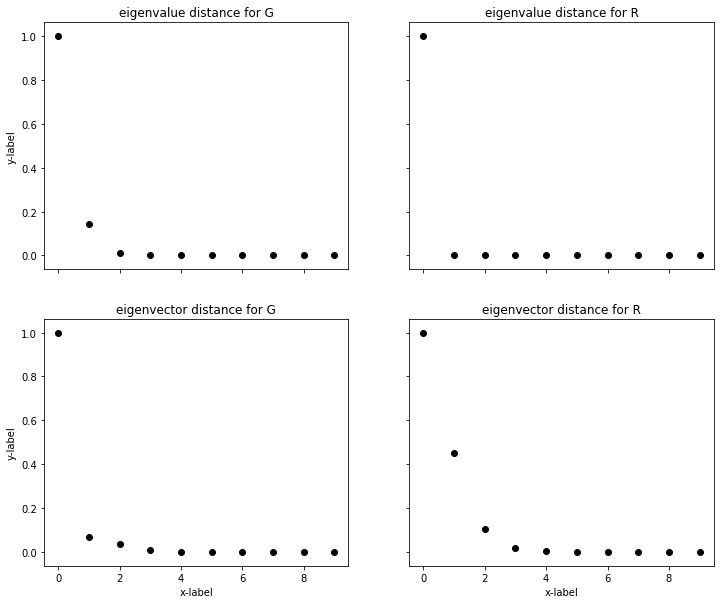

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
x = np.arange(0, 10)
axs[0, 0].scatter(x, evals_Glmbd[x], c='black')
axs[0, 0].set_title('eigenvalue distance for G')
axs[0, 1].scatter(x, evals_Rlmbd[x], c='black')
axs[0, 1].set_title('eigenvalue distance for R')
axs[1, 0].scatter(x, evals_Gpsi[x], c='black')
axs[1, 0].set_title('eigenvector distance for G')
axs[1, 1].scatter(x, evals_Rpsi[x], c='black')
axs[1, 1].set_title('eigenvector distance for R')
for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

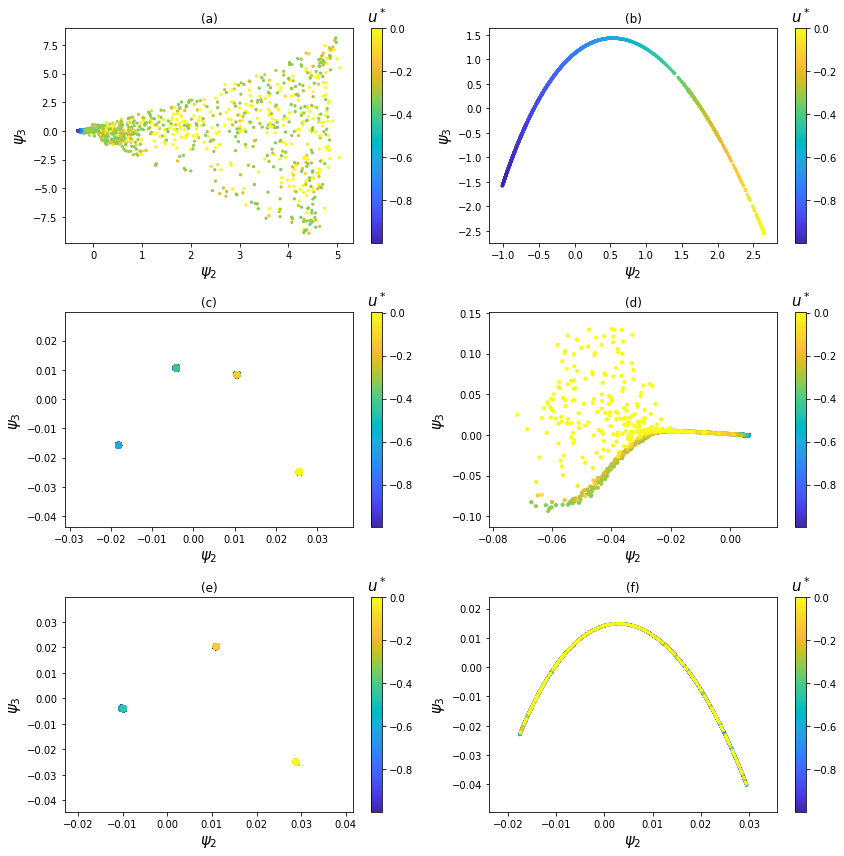

In [26]:

fig, axs = plt.subplots(3, 2, figsize=(12, 12))
plt.set_cmap('viridis')
a1=axs[0, 0].scatter(HD[:, 0], HD[:, 1],c= potentials_[:sample_size] , s=5, cmap=parula_map)
axs[0, 0].set_title('(a)')
a2=axs[0, 1].scatter(MAYER[:, 0], MAYER[:, 1], c=potentials_[:sample_size], s=5, cmap=parula_map)
axs[0, 1].set_title('(b)')
a3=axs[1, 0].scatter(evecs_Glmbd[:,1], evecs_Glmbd[:,2], c=potentials[:sample_size], cmap=parula_map)
axs[1, 0].set_title('(c)')
a4=axs[1, 1].scatter(evecs_Rlmbd[:,1], evecs_Rlmbd[:,2], c=potentials[:sample_size],s=10,cmap=parula_map)
axs[1, 1].set_title('(d)')
a5=axs[2, 0].scatter(evecs_Gpsi[:,1], evecs_Gpsi[:,2], c=potentials[:sample_size], cmap=parula_map)
axs[2, 0].set_title('(e)')
a6=axs[2, 1].scatter(evecs_Rpsi[:,1], evecs_Rpsi[:,2], c=potentials[:sample_size],s=5,cmap=parula_map)
axs[2, 1].set_title('(f)')
c1 = plt.colorbar(a1, ax=axs[0, 0])
c2 = plt.colorbar(a2, ax=axs[0, 1])
c3 = plt.colorbar(a3, ax=axs[1, 0])
c4 = plt.colorbar(a4, ax=axs[1, 1])
c5 = plt.colorbar(a5, ax=axs[2, 0])
c6 = plt.colorbar(a6, ax=axs[2, 1])
c1.ax.set_title('$u^*$', fontname='serif', fontsize=15)
c2.ax.set_title('$u^*$', fontname='serif', fontsize=15)
c3.ax.set_title('$u^*$', fontname='serif', fontsize=15)
c4.ax.set_title('$u^*$', fontname='serif', fontsize=15)
c5.ax.set_title('$u^*$', fontname='serif', fontsize=15)
c6.ax.set_title('$u^*$', fontname='serif', fontsize=15)
for ax in axs.flat:
    ax.set_xlabel('$\psi_2$', fontname='sans serif', fontsize=15)
    ax.set_ylabel('$\psi_3$', fontname='sans serif', fontsize=15)
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
fig.tight_layout()
plt.savefig("3p_energylandscape.png")

NameError: name 'rg_' is not defined

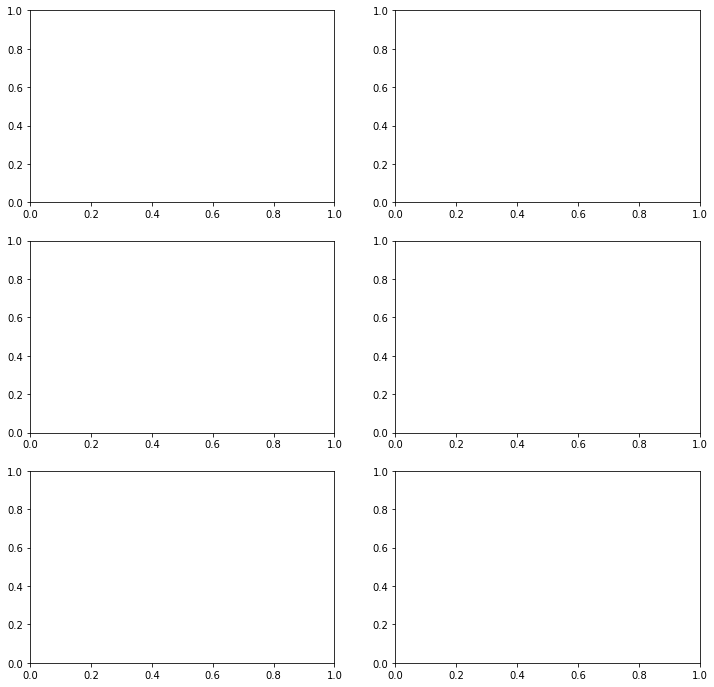

In [27]:

fig, axs = plt.subplots(3, 2, figsize=(12, 12))
plt.set_cmap('viridis')
a1=axs[0, 0].scatter(HD[:, 0], HD[:,1],c= rg_[:sample_size] , s=5, cmap=parula_map)
axs[0, 0].set_title('(a)')
a2=axs[0, 1].scatter(MAYER[:,0], MAYER[:,1], c=potentials_[:sample_size], s=5, cmap=parula_map)
axs[0, 1].set_title('(b)')
a3=axs[1, 0].scatter(evecs_Glmbd[:,1], evecs_Glmbd[:,2], c=connectivity[:sample_size],  cmap=parula_map)
axs[1, 0].set_title('(c)')
a4=axs[1, 1].scatter(evecs_Rlmbd[:,1], evecs_Rlmbd[:,2], c=rg[:sample_size],s=10,cmap=parula_map)
axs[1, 1].set_title('(d)')
a5=axs[2, 0].scatter(evecs_Gpsi[:,1], evecs_Gpsi[:,2], c=num_clusters[:sample_size],  cmap=parula_map)
axs[2, 0].set_title('(e)')
a6=axs[2, 1].scatter(evecs_Rpsi[:,1], evecs_Rpsi[:,2], c=num_clusters[:sample_size],s=5,cmap=parula_map)
axs[2, 1].set_title('(f)')
c1 = plt.colorbar(a1, ax=axs[0, 0])
c2 = plt.colorbar(a2, ax=axs[0, 1])
c3 = plt.colorbar(a3, ax=axs[1, 0])
c4 = plt.colorbar(a4, ax=axs[1, 1])
c5 = plt.colorbar(a5, ax=axs[2, 0])
c6 = plt.colorbar(a6, ax=axs[2, 1])
c1.ax.set_title('$r_g$', fontname='serif', fontsize=15)
c2.ax.set_title('$u^*$', fontname='serif', fontsize=15)
c3.ax.set_title('$c$', fontname='serif', fontsize=15)
c4.ax.set_title('$r_g$', fontname='serif', fontsize=15)
c5.ax.set_title('$n_c$', fontname='serif', fontsize=15)
c6.ax.set_title('$n_c$', fontname='serif', fontsize=15)
for ax in axs.flat:
    ax.set_xlabel('$\psi_2$', fontname='sans serif', fontsize=15)
    ax.set_ylabel('$\psi_3$', fontname='sans serif', fontsize=15)
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
fig.tight_layout()
plt.savefig("3p_correlation_plots.png")

In [ ]:
rg_ = np.zeros(shape=[len(rg)])
for i, j in enumerate(idx):
    rg_[j] = rg[i]


In [ ]:
clusters = []
num_clusters = []
adjacency_matrices = []
spectral_radius = []
spectrum = []
vecs = []
for i, config in enumerate(coordinates[:sample_size]):
    eva, evc = np.linalg.eig(G[i])
    eva = sorted(np.abs(eva), reverse=True)
    spectral_radius.append(np.abs(eva[0] - eva[1]))
    spectrum.append(np.abs(eva))
    clusters.append(cluster_map(G[i]))
    num_clusters.append(len(clusters[len(clusters)-1]))

#connectivity values
connectivity = []
connectivity_r = []
for i in range(sample_size):
    connectivity.append(np.mean(np.sum(G[i], axis=1)))
    connectivity_r.append(np.mean(np.sum(R[i], axis=1)))

#radius of gyration
rg = np.zeros(sample_size)
for i in range(sample_size):
    rg[i] = 0.5 * (1./len(L_R[i])) * np.trace(L_R[i])

#cluster weight distribution
cluster_weight_distribution = []
for i in range(len(clusters)):
    n_ = len(clusters[i])
    c_ = np.array([len(c) for c in clusters[i]])
    cluster_weight_distribution.append(np.sum(c_)/n_)

In [ ]:
n_b = np.zeros(shape=[len(rg)])
for i, j in enumerate(idx):
    n_b[j] = n_bonds[i]

In [ ]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [ ]:
fig = plt.figure(figsize=(12, 5))
axs1 = fig.add_subplot(121)
axs2 = fig.add_subplot(122)
a1 = axs1.scatter(isorank[:,0], isorank[:,1],  c=potentials_[:sample_size], s=10, cmap=parula_map)
axs1.set_title('(a)')
c1=plt.colorbar(a1, ax=axs1)
c1.ax.set_title('$u^*$', fontsize=15)
a2 = axs2.scatter(isorank[:,0], isorank[:,1], c=n_b[:sample_size], s=10, cmap=parula_map)
axs2.set_title('(b)')
c2=plt.colorbar(a2, ax=axs2)
c2.ax.set_title('$n_b$', fontsize=15)
axs1.set_xlabel('$\Psi_2$', fontsize=15)
axs1.set_ylabel('$\Psi_3$', fontsize=15)
axs2.set_xlabel('$\Psi_2$', fontsize=15)
axs2.set_ylabel('$\Psi_3$', fontsize=15)
plt.tight_layout()    
plt.savefig('isorank_space.png')


In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
x = np.arange(0, 10)
axs[0, 0].imshow(d_G_lmbd)
axs[0, 0].set_title('eigenvalue distance for G')
axs[0, 1].imshow(d_R_lmbd)
axs[0, 1].set_title('eigenvalue distance for R')
axs[1, 0].imshow(d_G_psi)
axs[1, 0].set_title('eigenvector distance for G')
axs[1, 1].imshow(d_R_psi)
axs[1, 1].set_title('eigenvector distance for R')
for ax in axs.flat:
    ax.set(xlabel='i', ylabel='j')
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [ ]:
np.where()

In [ ]:
idx = np.argsort(rg)

d_ = np.zeros(shape=d_R_lmbd.shape)
for i in range(len(d_R_lmbd)):
    for j in range(len(d_R_lmbd[0])):
        d_[i][j] = d_R_lmbd[idx[i]][idx[j]]

In [ ]:
plot_histogram(n_b)

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
x = np.arange(0, 10)
axs[0, 0].scatter(evecs_Glmbd[:,1], potentials,c=connectivity[:sample_size], s=5)
axs[0, 0].set_title('eigenvalue distance for G')
axs[0, 1].scatter(evecs_Rlmbd[:,1], potentials, c=rg[:sample_size], s=5)
axs[0, 1].set_title('eigenvalue distance for R')
axs[1, 0].scatter(evecs_Gpsi[:,1], potentials, c=num_clusters[:sample_size], s=5)
axs[1, 0].set_title('eigenvector distance for G')
axs[1, 1].scatter(evecs_Rpsi[:,1], potentials, c=num_clusters[:sample_size],s=5)
axs[1, 1].set_title('eigenvector distance for R')
for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [23]:
eigen = []
with open("../data/LJ3P_eigenvalues_MAYERbond.txt", 'r') as f:
    lines = f.readlines()
    for line in lines:
        data = line.split()
        eigen.append(np.array([float(data[1]), float(data[2]), float(data[3])]))
MAYER = np.asarray(eigen)

In [ ]:
eigen = []
with open("../data/LJ3P_eigenvalues_HD.txt", 'r') as f:
    lines = f.readlines()
    for line in lines:
        data = line.split()
        eigen.append(np.array([float(data[1]), float(data[2]), float(data[3])]))
HD = np.asarray(eigen)


In [22]:
eigen = []
with open("../data/LJ3P_eigenvalues_HD.txt", 'r') as f:
    lines = f.readlines()
    for line in lines:
        data = line.split()
        eigen.append(np.array([float(data[1]), float(data[2]), float(data[3])]))
HD = np.asarray(eigen)


In [ ]:
import csv
isorank = np.zeros(shape=[5001, 3])
nb = []
with open('dmap3pIso.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for i, row in enumerate(reader):
        isorank[i][0]= row['ev1']
        isorank[i][1]= row['ev2']
        isorank[i][2]= row['ev3']
        nb.append(row['connectivity'])

In [ ]:
eigen = []
with open("eig_space.txt", 'r') as f:
    lines = f.readlines()
    for line in lines:
        data = line.split()
        eigen.append(np.array([float(data[1]), float(data[2]), float(data[3])]))
isorank = np.asarray(eigen)


In [ ]:
from plotter import *
plot_2d(isorank[:, 0], isorank[:, 1], color=potentials_)

viscm not found, falling back on simple display


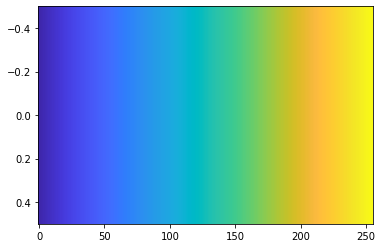

In [25]:
from matplotlib.colors import LinearSegmentedColormap

cm_data = [[0.2422, 0.1504, 0.6603],
[0.2444, 0.1534, 0.6728],
[0.2464, 0.1569, 0.6847],
[0.2484, 0.1607, 0.6961],
[0.2503, 0.1648, 0.7071],
[0.2522, 0.1689, 0.7179],
[0.254, 0.1732, 0.7286],
[0.2558, 0.1773, 0.7393],
[0.2576, 0.1814, 0.7501],
[0.2594, 0.1854, 0.761],
[0.2611, 0.1893, 0.7719],
[0.2628, 0.1932, 0.7828],
[0.2645, 0.1972, 0.7937],
[0.2661, 0.2011, 0.8043],
[0.2676, 0.2052, 0.8148],
[0.2691, 0.2094, 0.8249],
[0.2704, 0.2138, 0.8346],
[0.2717, 0.2184, 0.8439],
[0.2729, 0.2231, 0.8528],
[0.274, 0.228, 0.8612],
[0.2749, 0.233, 0.8692],
[0.2758, 0.2382, 0.8767],
[0.2766, 0.2435, 0.884],
[0.2774, 0.2489, 0.8908],
[0.2781, 0.2543, 0.8973],
[0.2788, 0.2598, 0.9035],
[0.2794, 0.2653, 0.9094],
[0.2798, 0.2708, 0.915],
[0.2802, 0.2764, 0.9204],
[0.2806, 0.2819, 0.9255],
[0.2809, 0.2875, 0.9305],
[0.2811, 0.293, 0.9352],
[0.2813, 0.2985, 0.9397],
[0.2814, 0.304, 0.9441],
[0.2814, 0.3095, 0.9483],
[0.2813, 0.315, 0.9524],
[0.2811, 0.3204, 0.9563],
[0.2809, 0.3259, 0.96],
[0.2807, 0.3313, 0.9636],
[0.2803, 0.3367, 0.967],
[0.2798, 0.3421, 0.9702],
[0.2791, 0.3475, 0.9733],
[0.2784, 0.3529, 0.9763],
[0.2776, 0.3583, 0.9791],
[0.2766, 0.3638, 0.9817],
[0.2754, 0.3693, 0.984],
[0.2741, 0.3748, 0.9862],
[0.2726, 0.3804, 0.9881],
[0.271, 0.386, 0.9898],
[0.2691, 0.3916, 0.9912],
[0.267, 0.3973, 0.9924],
[0.2647, 0.403, 0.9935],
[0.2621, 0.4088, 0.9946],
[0.2591, 0.4145, 0.9955],
[0.2556, 0.4203, 0.9965],
[0.2517, 0.4261, 0.9974],
[0.2473, 0.4319, 0.9983],
[0.2424, 0.4378, 0.9991],
[0.2369, 0.4437, 0.9996],
[0.2311, 0.4497, 0.9995],
[0.225, 0.4559, 0.9985],
[0.2189, 0.462, 0.9968],
[0.2128, 0.4682, 0.9948],
[0.2066, 0.4743, 0.9926],
[0.2006, 0.4803, 0.9906],
[0.195, 0.4861, 0.9887],
[0.1903, 0.4919, 0.9867],
[0.1869, 0.4975, 0.9844],
[0.1847, 0.503, 0.9819],
[0.1831, 0.5084, 0.9793],
[0.1818, 0.5138, 0.9766],
[0.1806, 0.5191, 0.9738],
[0.1795, 0.5244, 0.9709],
[0.1785, 0.5296, 0.9677],
[0.1778, 0.5349, 0.9641],
[0.1773, 0.5401, 0.9602],
[0.1768, 0.5452, 0.956],
[0.1764, 0.5504, 0.9516],
[0.1755, 0.5554, 0.9473],
[0.174, 0.5605, 0.9432],
[0.1716, 0.5655, 0.9393],
[0.1686, 0.5705, 0.9357],
[0.1649, 0.5755, 0.9323],
[0.161, 0.5805, 0.9289],
[0.1573, 0.5854, 0.9254],
[0.154, 0.5902, 0.9218],
[0.1513, 0.595, 0.9182],
[0.1492, 0.5997, 0.9147],
[0.1475, 0.6043, 0.9113],
[0.1461, 0.6089, 0.908],
[0.1446, 0.6135, 0.905],
[0.1429, 0.618, 0.9022],
[0.1408, 0.6226, 0.8998],
[0.1383, 0.6272, 0.8975],
[0.1354, 0.6317, 0.8953],
[0.1321, 0.6363, 0.8932],
[0.1288, 0.6408, 0.891],
[0.1253, 0.6453, 0.8887],
[0.1219, 0.6497, 0.8862],
[0.1185, 0.6541, 0.8834],
[0.1152, 0.6584, 0.8804],
[0.1119, 0.6627, 0.877],
[0.1085, 0.6669, 0.8734],
[0.1048, 0.671, 0.8695],
[0.1009, 0.675, 0.8653],
[0.0964, 0.6789, 0.8609],
[0.0914, 0.6828, 0.8562],
[0.0855, 0.6865, 0.8513],
[0.0789, 0.6902, 0.8462],
[0.0713, 0.6938, 0.8409],
[0.0628, 0.6972, 0.8355],
[0.0535, 0.7006, 0.8299],
[0.0433, 0.7039, 0.8242],
[0.0328, 0.7071, 0.8183],
[0.0234, 0.7103, 0.8124],
[0.0155, 0.7133, 0.8064],
[0.0091, 0.7163, 0.8003],
[0.0046, 0.7192, 0.7941],
[0.0019, 0.722, 0.7878],
[0.0009, 0.7248, 0.7815],
[0.0018, 0.7275, 0.7752],
[0.0046, 0.7301, 0.7688],
[0.0094, 0.7327, 0.7623],
[0.0162, 0.7352, 0.7558],
[0.0253, 0.7376, 0.7492],
[0.0369, 0.74, 0.7426],
[0.0504, 0.7423, 0.7359],
[0.0638, 0.7446, 0.7292],
[0.077, 0.7468, 0.7224],
[0.0899, 0.7489, 0.7156],
[0.1023, 0.751, 0.7088],
[0.1141, 0.7531, 0.7019],
[0.1252, 0.7552, 0.695],
[0.1354, 0.7572, 0.6881],
[0.1448, 0.7593, 0.6812],
[0.1532, 0.7614, 0.6741],
[0.1609, 0.7635, 0.6671],
[0.1678, 0.7656, 0.6599],
[0.1741, 0.7678, 0.6527],
[0.1799, 0.7699, 0.6454],
[0.1853, 0.7721, 0.6379],
[0.1905, 0.7743, 0.6303],
[0.1954, 0.7765, 0.6225],
[0.2003, 0.7787, 0.6146],
[0.2061, 0.7808, 0.6065],
[0.2118, 0.7828, 0.5983],
[0.2178, 0.7849, 0.5899],
[0.2244, 0.7869, 0.5813],
[0.2318, 0.7887, 0.5725],
[0.2401, 0.7905, 0.5636],
[0.2491, 0.7922, 0.5546],
[0.2589, 0.7937, 0.5454],
[0.2695, 0.7951, 0.536],
[0.2809, 0.7964, 0.5266],
[0.2929, 0.7975, 0.517],
[0.3052, 0.7985, 0.5074],
[0.3176, 0.7994, 0.4975],
[0.3301, 0.8002, 0.4876],
[0.3424, 0.8009, 0.4774],
[0.3548, 0.8016, 0.4669],
[0.3671, 0.8021, 0.4563],
[0.3795, 0.8026, 0.4454],
[0.3921, 0.8029, 0.4344],
[0.405, 0.8031, 0.4233],
[0.4184, 0.803, 0.4122],
[0.4322, 0.8028, 0.4013],
[0.4463, 0.8024, 0.3904],
[0.4608, 0.8018, 0.3797],
[0.4753, 0.8011, 0.3691],
[0.4899, 0.8002, 0.3586],
[0.5044, 0.7993, 0.348],
[0.5187, 0.7982, 0.3374],
[0.5329, 0.797, 0.3267],
[0.547, 0.7957, 0.3159],
[0.5609, 0.7943, 0.305],
[0.5748, 0.7929, 0.2941],
[0.5886, 0.7913, 0.2833],
[0.6024, 0.7896, 0.2726],
[0.6161, 0.7878, 0.2622],
[0.6297, 0.7859, 0.2521],
[0.6433, 0.7839, 0.2423],
[0.6567, 0.7818, 0.2329],
[0.6701, 0.7796, 0.2239],
[0.6833, 0.7773, 0.2155],
[0.6963, 0.775, 0.2075],
[0.7091, 0.7727, 0.1998],
[0.7218, 0.7703, 0.1924],
[0.7344, 0.7679, 0.1852],
[0.7468, 0.7654, 0.1782],
[0.759, 0.7629, 0.1717],
[0.771, 0.7604, 0.1658],
[0.7829, 0.7579, 0.1608],
[0.7945, 0.7554, 0.157],
[0.806, 0.7529, 0.1546],
[0.8172, 0.7505, 0.1535],
[0.8281, 0.7481, 0.1536],
[0.8389, 0.7457, 0.1546],
[0.8495, 0.7435, 0.1564],
[0.86, 0.7413, 0.1587],
[0.8703, 0.7392, 0.1615],
[0.8804, 0.7372, 0.165],
[0.8903, 0.7353, 0.1695],
[0.9, 0.7336, 0.1749],
[0.9093, 0.7321, 0.1815],
[0.9184, 0.7308, 0.189],
[0.9272, 0.7298, 0.1973],
[0.9357, 0.729, 0.2061],
[0.944, 0.7285, 0.2151],
[0.9523, 0.7284, 0.2237],
[0.9606, 0.7285, 0.2312],
[0.9689, 0.7292, 0.2373],
[0.977, 0.7304, 0.2418],
[0.9842, 0.733, 0.2446],
[0.99, 0.7365, 0.2429],
[0.9946, 0.7407, 0.2394],
[0.9966, 0.7458, 0.2351],
[0.9971, 0.7513, 0.2309],
[0.9972, 0.7569, 0.2267],
[0.9971, 0.7626, 0.2224],
[0.9969, 0.7683, 0.2181],
[0.9966, 0.774, 0.2138],
[0.9962, 0.7798, 0.2095],
[0.9957, 0.7856, 0.2053],
[0.9949, 0.7915, 0.2012],
[0.9938, 0.7974, 0.1974],
[0.9923, 0.8034, 0.1939],
[0.9906, 0.8095, 0.1906],
[0.9885, 0.8156, 0.1875],
[0.9861, 0.8218, 0.1846],
[0.9835, 0.828, 0.1817],
[0.9807, 0.8342, 0.1787],
[0.9778, 0.8404, 0.1757],
[0.9748, 0.8467, 0.1726],
[0.972, 0.8529, 0.1695],
[0.9694, 0.8591, 0.1665],
[0.9671, 0.8654, 0.1636],
[0.9651, 0.8716, 0.1608],
[0.9634, 0.8778, 0.1582],
[0.9619, 0.884, 0.1557],
[0.9608, 0.8902, 0.1532],
[0.9601, 0.8963, 0.1507],
[0.9596, 0.9023, 0.148],
[0.9595, 0.9084, 0.145],
[0.9597, 0.9143, 0.1418],
[0.9601, 0.9203, 0.1382],
[0.9608, 0.9262, 0.1344],
[0.9618, 0.932, 0.1304],
[0.9629, 0.9379, 0.1261],
[0.9642, 0.9437, 0.1216],
[0.9657, 0.9494, 0.1168],
[0.9674, 0.9552, 0.1116],
[0.9692, 0.9609, 0.1061],
[0.9711, 0.9667, 0.1001],
[0.973, 0.9724, 0.0938],
[0.9749, 0.9782, 0.0872],
[0.9769, 0.9839, 0.0805]]

parula_map = LinearSegmentedColormap.from_list('parula', cm_data)
# For use of "viscm view"
test_cm = parula_map

if __name__ == "__main__":
    import matplotlib.pyplot as plt
    import numpy as np

    try:
        from viscm import viscm
        viscm(parula_map)
    except ImportError:
        print("viscm not found, falling back on simple display")
        plt.imshow(np.linspace(0, 100, 256)[None, :], aspect='auto',
                   cmap=parula_map)
    plt.show()

In [ ]:
plot_2d(isorank[:, 2], n_bonds)

In [ ]:
idx=np.where(np.array(num_clusters)==1)[0]

In [ ]:
plot_histogram(potentials[idx])